Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


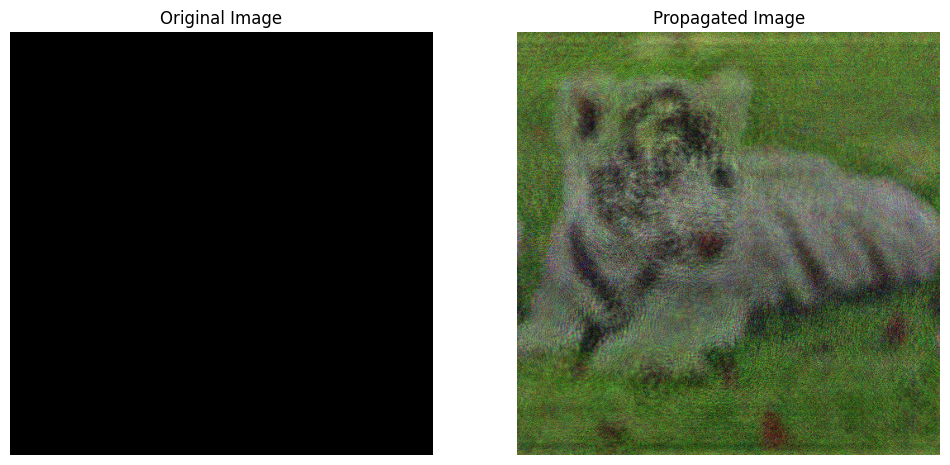

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Propagation function using Fourier optics principles
def propagate(field, distance, wavelength, pixel_size):
    """
    Parameters:
        field: torch.Tensor - The input complex field (HxW complex tensor)
        distance: float - Propagation distance in meters
        wavelength: float - Wavelength in meters
        pixel_size: float - Pixel size in meters
    Returns:
        torch.Tensor - Propagated field
    """
    H, W = field.shape
    k = 2 * np.pi / wavelength  # Wavenumber

    # Create frequency coordinates
    fx = torch.fft.fftfreq(W, d=pixel_size)
    fy = torch.fft.fftfreq(H, d=pixel_size)
    FX, FY = torch.meshgrid(fx, fy, indexing='ij')  # Fixed indexing
    F2 = FX**2 + FY**2

    # Transfer function for free-space propagation
    H = torch.exp(-1j * k * distance * torch.sqrt(torch.clamp(1 - (wavelength**2) * F2, min=1e-10)))

    # Apply the propagation in Fourier domain
    field_ft = torch.fft.fft2(field)
    field_ft_prop = field_ft * H
    propagated_field = torch.fft.ifft2(field_ft_prop)

    return propagated_field

# Constants
wavelength = 515e-9  # 515 nm in meters
distance = 30e-3  # 30 mm in meters
pixel_size = 10e-6  # Assume pixel size of 10 micrometers

# Load the unknown.npy file and convert it to a complex tensor
data = np.load('unknown.npy')  # Load as numpy array
if data.ndim == 3 and data.shape[-1] == 3:  # Check if RGB
    data = torch.tensor(data / 255.0, dtype=torch.float32)  # Normalize to [0, 1]

# Initialize propagated fields for each color channel
propagated_fields = []

for channel in range(3):  # Loop through R, G, B channels
    amplitude = data[:, :, channel]
    phase = torch.zeros_like(amplitude)  # Assuming phase is initially zero
    field = amplitude * torch.exp(1j * phase)  # Create complex field

    # Propagate the field
    propagated_field = propagate(field, distance, wavelength, pixel_size)
    propagated_fields.append(torch.abs(propagated_field))  # Store the amplitude

# Combine propagated channels back into a color image
propagated_image = torch.stack(propagated_fields, dim=-1).numpy()

# Normalize propagated image for visualization
propagated_image = propagated_image / np.max(propagated_image)

# Plot the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(data.numpy())  # Ensure data is in [0, 1] range
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Propagated Image")
plt.imshow(propagated_image)
plt.axis('off')

plt.show()


/tmp/ipykernel_92308/3780833178.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_tensor = torch.tensor(data, dtype=torch.complex64)  # Use single precision for efficiency


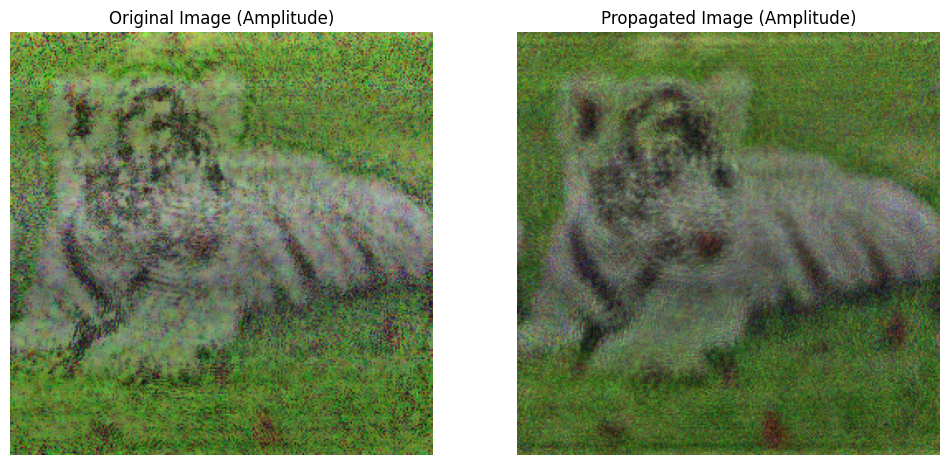

In [6]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

# Propagation function using Fourier optics principles
def propagate(field, distance, wavelength, pixel_size):
    """
    Parameters:
        field: torch.Tensor - The input complex field (HxW complex tensor)
        distance: float - Propagation distance in meters
        wavelength: float - Wavelength in meters
        pixel_size: float - Pixel size in meters
    Returns:
        torch.Tensor - Propagated field
    """
    H, W = field.shape
    k = 2 * np.pi / wavelength  # Wavenumber

    # Create frequency coordinates
    fx = torch.fft.fftfreq(W, d=pixel_size)
    fy = torch.fft.fftfreq(H, d=pixel_size)
    FX, FY = torch.meshgrid(fx, fy, indexing='ij')  # Correct indexing
    F2 = FX**2 + FY**2

    # Transfer function for free-space propagation
    sqrt_term = torch.clamp(1 - (wavelength**2) * F2, min=1e-10)  # Clamp to avoid invalid sqrt
    H = torch.exp(-1j * k * distance * torch.sqrt(sqrt_term))

    # Apply the propagation in Fourier domain
    field_ft = torch.fft.fft2(field)
    field_ft_prop = field_ft * H
    propagated_field = torch.fft.ifft2(field_ft_prop)

    return propagated_field

# Constants for propagation
wavelength = 515e-9  # 515 nm in meters
distance = 30e-3  # 30 mm in meters
pixel_size = 10e-6  # Pixel size in meters (10 μm)

# Convert the loaded data into a PyTorch tensor
data_tensor = torch.tensor(data, dtype=torch.complex64)  # Use single precision for efficiency

# Initialize propagated fields for each color channel
propagated_fields = []

# Perform propagation for each channel
for channel in range(3):  # Loop through R, G, B channels
    field = data_tensor[:, :, channel]  # Extract channel data (complex field)
    propagated_field = propagate(field, distance, wavelength, pixel_size)
    propagated_fields.append(torch.abs(propagated_field))  # Store amplitude

# Combine propagated channels into an RGB image
propagated_image = torch.stack(propagated_fields, dim=-1).numpy()

# Normalize the propagated image for visualization
propagated_image_normalized = propagated_image / np.max(propagated_image)

# Convert data tensor to NumPy for visualization
data_numpy = data_tensor.numpy()  # Convert tensor to NumPy array
original_amplitude = np.abs(data_numpy)  # Take amplitude from the original complex data
original_amplitude_normalized = original_amplitude / np.max(original_amplitude)  # Normalize

# Downscale propagated image for display (optional, e.g., reduce size by 2x)
propagated_image_normalized = zoom(propagated_image_normalized, zoom=(0.5, 0.5, 1), order=1)  # Downscale 2x
original_amplitude_downscaled = zoom(original_amplitude_normalized, zoom=(0.5, 0.5, 1), order=1)  # Downscale 2x

# Plot the results
plt.figure(figsize=(12, 6))

# Plot original image (amplitude of input field)
plt.subplot(1, 2, 1)
plt.title("Original Image (Amplitude)")
plt.imshow(original_amplitude_downscaled, cmap='viridis')
plt.axis('off')

# Plot propagated image
plt.subplot(1, 2, 2)
plt.title("Propagated Image (Amplitude)")
plt.imshow(propagated_image_normalized)
plt.axis('off')

plt.show()


/tmp/ipykernel_92308/3280677568.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_tensor = torch.tensor(data, dtype=torch.complex64)  # Use single precision for efficiency


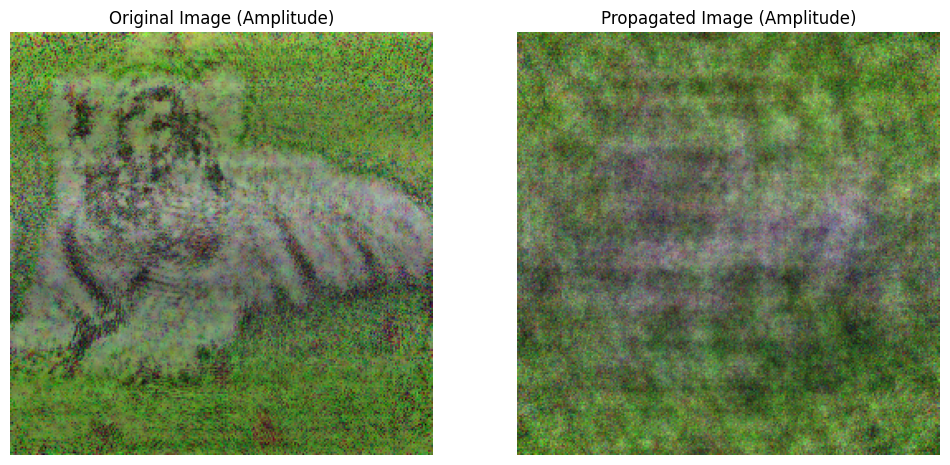

In [7]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

# Propagation function using Fourier optics principles
def propagate(field, distance, wavelength, pixel_size):
    """
    Parameters:
        field: torch.Tensor - The input complex field (HxW complex tensor)
        distance: float - Propagation distance in meters
        wavelength: float - Wavelength in meters
        pixel_size: float - Pixel size in meters
    Returns:
        torch.Tensor - Propagated field
    """
    H, W = field.shape
    k = 2 * np.pi / wavelength  # Wavenumber

    # Create frequency coordinates
    fx = torch.fft.fftfreq(W, d=pixel_size)
    fy = torch.fft.fftfreq(H, d=pixel_size)
    FX, FY = torch.meshgrid(fx, fy, indexing='ij')  # Correct indexing
    F2 = FX**2 + FY**2

    # Transfer function for free-space propagation
    sqrt_term = torch.clamp(1 - (wavelength**2) * F2, min=1e-10)  # Clamp to avoid invalid sqrt
    H = torch.exp(-1j * k * distance * torch.sqrt(sqrt_term))

    # Apply the propagation in Fourier domain
    field_ft = torch.fft.fft2(field)
    field_ft_prop = field_ft * H
    propagated_field = torch.fft.ifft2(field_ft_prop)

    return propagated_field

# Constants for propagation
wavelength = 515e-9  # 515 nm in meters
distance = 30e-3  # 30 mm in meters
pixel_size = 1e-6  # Pixel size in meters (10 μm)

# Convert the loaded data into a PyTorch tensor
data_tensor = torch.tensor(data, dtype=torch.complex64)  # Use single precision for efficiency

# Initialize propagated fields for each color channel
propagated_fields = []

# Perform propagation for each channel
for channel in range(3):  # Loop through R, G, B channels
    field = data_tensor[:, :, channel]  # Extract channel data (complex field)
    propagated_field = propagate(field, distance, wavelength, pixel_size)
    propagated_fields.append(torch.abs(propagated_field))  # Store amplitude

# Combine propagated channels into an RGB image
propagated_image = torch.stack(propagated_fields, dim=-1).numpy()

# Normalize the propagated image for visualization
propagated_image_normalized = propagated_image / np.max(propagated_image)

# Convert data tensor to NumPy for visualization
data_numpy = data_tensor.numpy()  # Convert tensor to NumPy array
original_amplitude = np.abs(data_numpy)  # Take amplitude from the original complex data
original_amplitude_normalized = original_amplitude / np.max(original_amplitude)  # Normalize

# Downscale propagated image for display (optional, e.g., reduce size by 2x)
propagated_image_normalized = zoom(propagated_image_normalized, zoom=(0.5, 0.5, 1), order=1)  # Downscale 2x
original_amplitude_downscaled = zoom(original_amplitude_normalized, zoom=(0.5, 0.5, 1), order=1)  # Downscale 2x

# Plot the results
plt.figure(figsize=(12, 6))

# Plot original image (amplitude of input field)
plt.subplot(1, 2, 1)
plt.title("Original Image (Amplitude)")
plt.imshow(original_amplitude_downscaled, cmap='viridis')
plt.axis('off')

# Plot propagated image
plt.subplot(1, 2, 2)
plt.title("Propagated Image (Amplitude)")
plt.imshow(propagated_image_normalized)
plt.axis('off')

plt.show()


/tmp/ipykernel_92308/722966320.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_tensor = torch.tensor(data, dtype=torch.complex64)  # Use single precision for efficiency


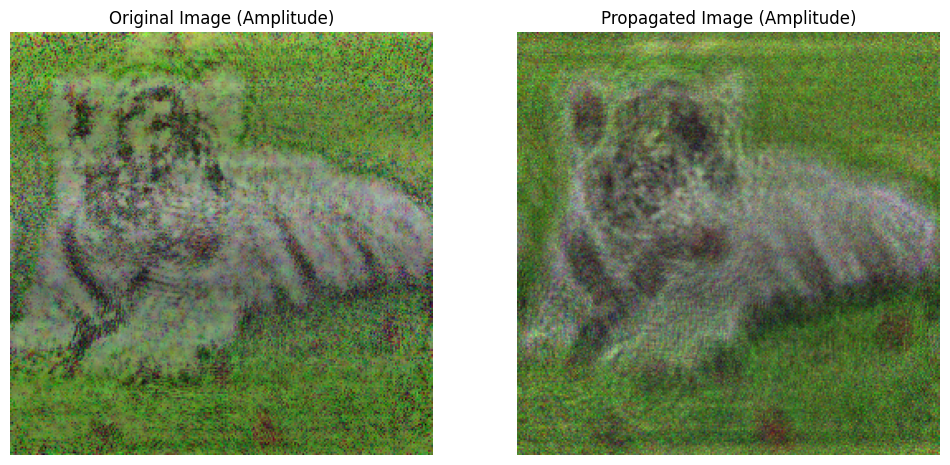

In [8]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

# Propagation function using Fourier optics principles
def propagate(field, distance, wavelength, pixel_size):
    """
    Parameters:
        field: torch.Tensor - The input complex field (HxW complex tensor)
        distance: float - Propagation distance in meters
        wavelength: float - Wavelength in meters
        pixel_size: float - Pixel size in meters
    Returns:
        torch.Tensor - Propagated field
    """
    H, W = field.shape
    k = 2 * np.pi / wavelength  # Wavenumber

    # Create frequency coordinates
    fx = torch.fft.fftfreq(W, d=pixel_size)
    fy = torch.fft.fftfreq(H, d=pixel_size)
    FX, FY = torch.meshgrid(fx, fy, indexing='ij')  # Correct indexing
    F2 = FX**2 + FY**2

    # Transfer function for free-space propagation
    sqrt_term = torch.clamp(1 - (wavelength**2) * F2, min=1e-10)  # Clamp to avoid invalid sqrt
    H = torch.exp(-1j * k * distance * torch.sqrt(sqrt_term))

    # Apply the propagation in Fourier domain
    field_ft = torch.fft.fft2(field)
    field_ft_prop = field_ft * H
    propagated_field = torch.fft.ifft2(field_ft_prop)

    return propagated_field

# Constants for propagation
wavelength = 515e-9  # 515 nm in meters
distance = 30e-3  # 30 mm in meters
pixel_size = 5e-6  # Pixel size in meters (10 μm)

# Convert the loaded data into a PyTorch tensor
data_tensor = torch.tensor(data, dtype=torch.complex64)  # Use single precision for efficiency

# Initialize propagated fields for each color channel
propagated_fields = []

# Perform propagation for each channel
for channel in range(3):  # Loop through R, G, B channels
    field = data_tensor[:, :, channel]  # Extract channel data (complex field)
    propagated_field = propagate(field, distance, wavelength, pixel_size)
    propagated_fields.append(torch.abs(propagated_field))  # Store amplitude

# Combine propagated channels into an RGB image
propagated_image = torch.stack(propagated_fields, dim=-1).numpy()

# Normalize the propagated image for visualization
propagated_image_normalized = propagated_image / np.max(propagated_image)

# Convert data tensor to NumPy for visualization
data_numpy = data_tensor.numpy()  # Convert tensor to NumPy array
original_amplitude = np.abs(data_numpy)  # Take amplitude from the original complex data
original_amplitude_normalized = original_amplitude / np.max(original_amplitude)  # Normalize

# Downscale propagated image for display (optional, e.g., reduce size by 2x)
propagated_image_normalized = zoom(propagated_image_normalized, zoom=(0.5, 0.5, 1), order=1)  # Downscale 2x
original_amplitude_downscaled = zoom(original_amplitude_normalized, zoom=(0.5, 0.5, 1), order=1)  # Downscale 2x

# Plot the results
plt.figure(figsize=(12, 6))

# Plot original image (amplitude of input field)
plt.subplot(1, 2, 1)
plt.title("Original Image (Amplitude)")
plt.imshow(original_amplitude_downscaled, cmap='viridis')
plt.axis('off')

# Plot propagated image
plt.subplot(1, 2, 2)
plt.title("Propagated Image (Amplitude)")
plt.imshow(propagated_image_normalized)
plt.axis('off')

plt.show()


/tmp/ipykernel_92308/3553260048.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_tensor = torch.tensor(data, dtype=torch.complex64)  # Use single precision for efficiency


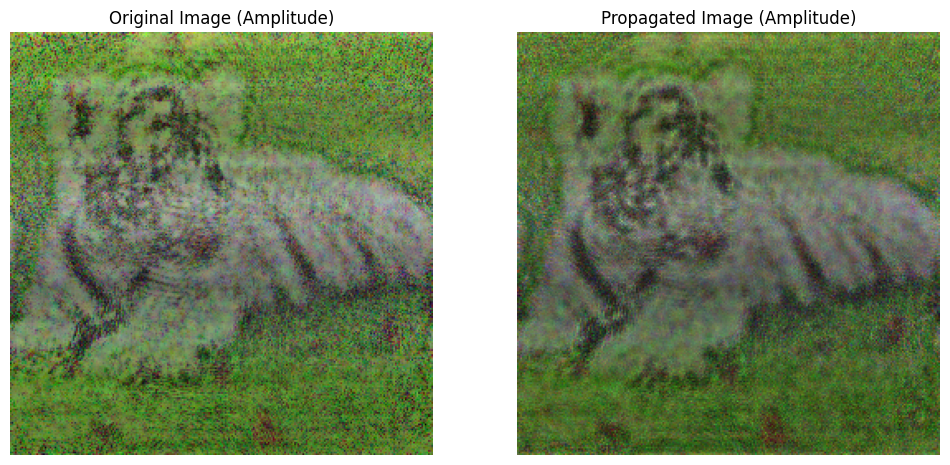

In [9]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

# Propagation function using Fourier optics principles
def propagate(field, distance, wavelength, pixel_size):
    """
    Parameters:
        field: torch.Tensor - The input complex field (HxW complex tensor)
        distance: float - Propagation distance in meters
        wavelength: float - Wavelength in meters
        pixel_size: float - Pixel size in meters
    Returns:
        torch.Tensor - Propagated field
    """
    H, W = field.shape
    k = 2 * np.pi / wavelength  # Wavenumber

    # Create frequency coordinates
    fx = torch.fft.fftfreq(W, d=pixel_size)
    fy = torch.fft.fftfreq(H, d=pixel_size)
    FX, FY = torch.meshgrid(fx, fy, indexing='ij')  # Correct indexing
    F2 = FX**2 + FY**2

    # Transfer function for free-space propagation
    sqrt_term = torch.clamp(1 - (wavelength**2) * F2, min=1e-10)  # Clamp to avoid invalid sqrt
    H = torch.exp(-1j * k * distance * torch.sqrt(sqrt_term))

    # Apply the propagation in Fourier domain
    field_ft = torch.fft.fft2(field)
    field_ft_prop = field_ft * H
    propagated_field = torch.fft.ifft2(field_ft_prop)

    return propagated_field

# Constants for propagation
wavelength = 515e-9  # 515 nm in meters
distance = 30e-3  # 30 mm in meters
pixel_size = 20e-6  # Pixel size in meters (10 μm)

# Convert the loaded data into a PyTorch tensor
data_tensor = torch.tensor(data, dtype=torch.complex64)  # Use single precision for efficiency

# Initialize propagated fields for each color channel
propagated_fields = []

# Perform propagation for each channel
for channel in range(3):  # Loop through R, G, B channels
    field = data_tensor[:, :, channel]  # Extract channel data (complex field)
    propagated_field = propagate(field, distance, wavelength, pixel_size)
    propagated_fields.append(torch.abs(propagated_field))  # Store amplitude

# Combine propagated channels into an RGB image
propagated_image = torch.stack(propagated_fields, dim=-1).numpy()

# Normalize the propagated image for visualization
propagated_image_normalized = propagated_image / np.max(propagated_image)

# Convert data tensor to NumPy for visualization
data_numpy = data_tensor.numpy()  # Convert tensor to NumPy array
original_amplitude = np.abs(data_numpy)  # Take amplitude from the original complex data
original_amplitude_normalized = original_amplitude / np.max(original_amplitude)  # Normalize

# Downscale propagated image for display (optional, e.g., reduce size by 2x)
propagated_image_normalized = zoom(propagated_image_normalized, zoom=(0.5, 0.5, 1), order=1)  # Downscale 2x
original_amplitude_downscaled = zoom(original_amplitude_normalized, zoom=(0.5, 0.5, 1), order=1)  # Downscale 2x

# Plot the results
plt.figure(figsize=(12, 6))

# Plot original image (amplitude of input field)
plt.subplot(1, 2, 1)
plt.title("Original Image (Amplitude)")
plt.imshow(original_amplitude_downscaled, cmap='viridis')
plt.axis('off')

# Plot propagated image
plt.subplot(1, 2, 2)
plt.title("Propagated Image (Amplitude)")
plt.imshow(propagated_image_normalized)
plt.axis('off')

plt.show()


/tmp/ipykernel_92308/2243016031.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_tensor = torch.tensor(data, dtype=torch.complex64)  # Use single precision for efficiency


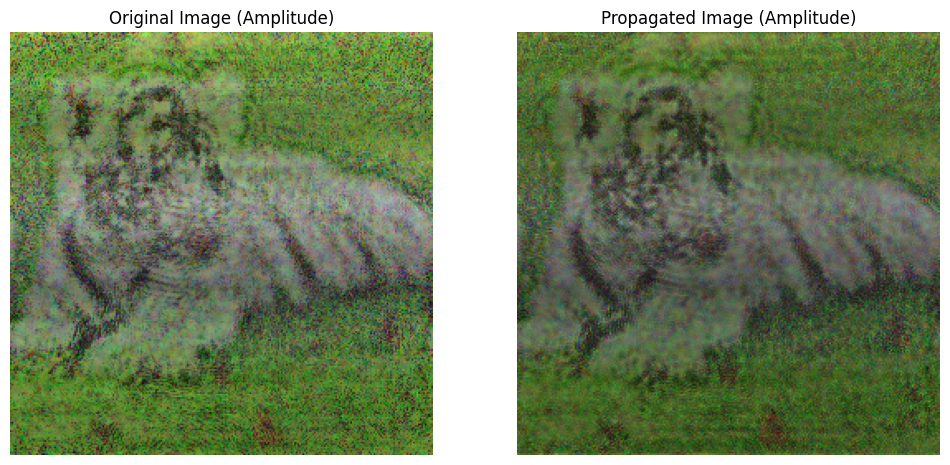

In [11]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

# Propagation function using Fourier optics principles
def propagate(field, distance, wavelength, pixel_size):
    """
    Parameters:
        field: torch.Tensor - The input complex field (HxW complex tensor)
        distance: float - Propagation distance in meters
        wavelength: float - Wavelength in meters
        pixel_size: float - Pixel size in meters
    Returns:
        torch.Tensor - Propagated field
    """
    H, W = field.shape
    k = 2 * np.pi / wavelength  # Wavenumber

    # Create frequency coordinates
    fx = torch.fft.fftfreq(W, d=pixel_size)
    fy = torch.fft.fftfreq(H, d=pixel_size)
    FX, FY = torch.meshgrid(fx, fy, indexing='ij')  # Correct indexing
    F2 = FX**2 + FY**2

    # Transfer function for free-space propagation
    sqrt_term = torch.clamp(1 - (wavelength**2) * F2, min=1e-10)  # Clamp to avoid invalid sqrt
    H = torch.exp(-1j * k * distance * torch.sqrt(sqrt_term))

    # Apply the propagation in Fourier domain
    field_ft = torch.fft.fft2(field)
    field_ft_prop = field_ft * H
    propagated_field = torch.fft.ifft2(field_ft_prop)

    return propagated_field

# Constants for propagation
wavelength = 515e-9  # 515 nm in meters
distance = 30e-3  # 30 mm in meters
pixel_size = 30e-6  # Pixel size in meters (10 μm)

# Convert the loaded data into a PyTorch tensor
data_tensor = torch.tensor(data, dtype=torch.complex64)  # Use single precision for efficiency

# Initialize propagated fields for each color channel
propagated_fields = []

# Perform propagation for each channel
for channel in range(3):  # Loop through R, G, B channels
    field = data_tensor[:, :, channel]  # Extract channel data (complex field)
    propagated_field = propagate(field, distance, wavelength, pixel_size)
    propagated_fields.append(torch.abs(propagated_field))  # Store amplitude

# Combine propagated channels into an RGB image
propagated_image = torch.stack(propagated_fields, dim=-1).numpy()

# Normalize the propagated image for visualization
propagated_image_normalized = propagated_image / np.max(propagated_image)

# Convert data tensor to NumPy for visualization
data_numpy = data_tensor.numpy()  # Convert tensor to NumPy array
original_amplitude = np.abs(data_numpy)  # Take amplitude from the original complex data
original_amplitude_normalized = original_amplitude / np.max(original_amplitude)  # Normalize

# Downscale propagated image for display (optional, e.g., reduce size by 2x)
propagated_image_normalized = zoom(propagated_image_normalized, zoom=(0.5, 0.5, 1), order=1)  # Downscale 2x
original_amplitude_downscaled = zoom(original_amplitude_normalized, zoom=(0.5, 0.5, 1), order=1)  # Downscale 2x

# Plot the results
plt.figure(figsize=(12, 6))

# Plot original image (amplitude of input field)
plt.subplot(1, 2, 1)
plt.title("Original Image (Amplitude)")
plt.imshow(original_amplitude_downscaled, cmap='viridis')
plt.axis('off')

# Plot propagated image
plt.subplot(1, 2, 2)
plt.title("Propagated Image (Amplitude)")
plt.imshow(propagated_image_normalized)
plt.axis('off')

plt.show()


/tmp/ipykernel_92308/2987114978.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_tensor = torch.tensor(data, dtype=torch.complex64)  # Use single precision for efficiency


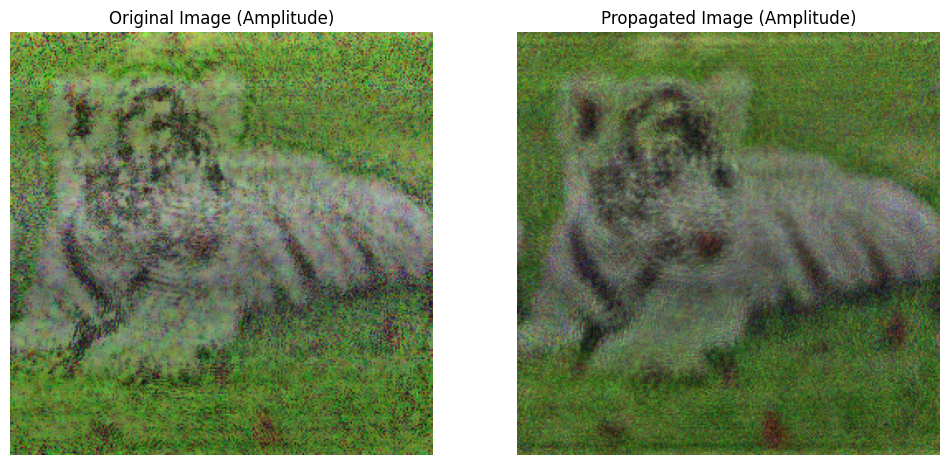

In [12]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

# Propagation function using Fourier optics principles
def propagate(field, distance, wavelength, pixel_size):
    """
    Parameters:
        field: torch.Tensor - The input complex field (HxW complex tensor)
        distance: float - Propagation distance in meters
        wavelength: float - Wavelength in meters
        pixel_size: float - Pixel size in meters
    Returns:
        torch.Tensor - Propagated field
    """
    H, W = field.shape
    k = 2 * np.pi / wavelength  # Wavenumber

    # Create frequency coordinates
    fx = torch.fft.fftfreq(W, d=pixel_size)
    fy = torch.fft.fftfreq(H, d=pixel_size)
    FX, FY = torch.meshgrid(fx, fy, indexing='ij')  # Correct indexing
    F2 = FX**2 + FY**2

    # Transfer function for free-space propagation
    sqrt_term = torch.clamp(1 - (wavelength**2) * F2, min=1e-10)  # Clamp to avoid invalid sqrt
    H = torch.exp(-1j * k * distance * torch.sqrt(sqrt_term))

    # Apply the propagation in Fourier domain
    field_ft = torch.fft.fft2(field)
    field_ft_prop = field_ft * H
    propagated_field = torch.fft.ifft2(field_ft_prop)

    return propagated_field

# Constants for propagation
wavelength = 515e-9  # 515 nm in meters
distance = 30e-3  # 30 mm in meters
pixel_size = 10e-6  # Corrected pixel size (10 μm)

# Convert the loaded data into a PyTorch tensor
data_tensor = torch.tensor(data, dtype=torch.complex64)  # Use single precision for efficiency

# Initialize propagated fields for each color channel
propagated_fields = []

# Perform propagation for each channel
for channel in range(3):  # Loop through R, G, B channels
    field = data_tensor[:, :, channel]  # Extract channel data (complex field)
    propagated_field = propagate(field, distance, wavelength, pixel_size)
    propagated_fields.append(torch.abs(propagated_field))  # Store amplitude

# Combine propagated channels into an RGB image
propagated_image = torch.stack(propagated_fields, dim=-1).numpy()

# Normalize the propagated image for visualization
propagated_image_normalized = propagated_image / np.max(propagated_image)

# Convert data tensor to NumPy for visualization
data_numpy = data_tensor.numpy()  # Convert tensor to NumPy array
original_amplitude = np.abs(data_numpy)  # Take amplitude from the original complex data
original_amplitude_normalized = original_amplitude / np.max(original_amplitude)  # Normalize

# Downscale propagated image for display (optional, e.g., reduce size by 2x)
propagated_image_normalized = zoom(propagated_image_normalized, zoom=(0.5, 0.5, 1), order=1)  # Downscale 2x
original_amplitude_downscaled = zoom(original_amplitude_normalized, zoom=(0.5, 0.5, 1), order=1)  # Downscale 2x

# Plot the results
plt.figure(figsize=(12, 6))

# Plot original image (amplitude of input field)
plt.subplot(1, 2, 1)
plt.title("Original Image (Amplitude)")
plt.imshow(original_amplitude_downscaled, cmap='viridis')
plt.axis('off')

# Plot propagated image
plt.subplot(1, 2, 2)
plt.title("Propagated Image (Amplitude)")
plt.imshow(propagated_image_normalized)
plt.axis('off')

plt.show()


/tmp/ipykernel_92308/2564981958.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_tensor = torch.tensor(data, dtype=torch.complex64)  # Use single precision for efficiency


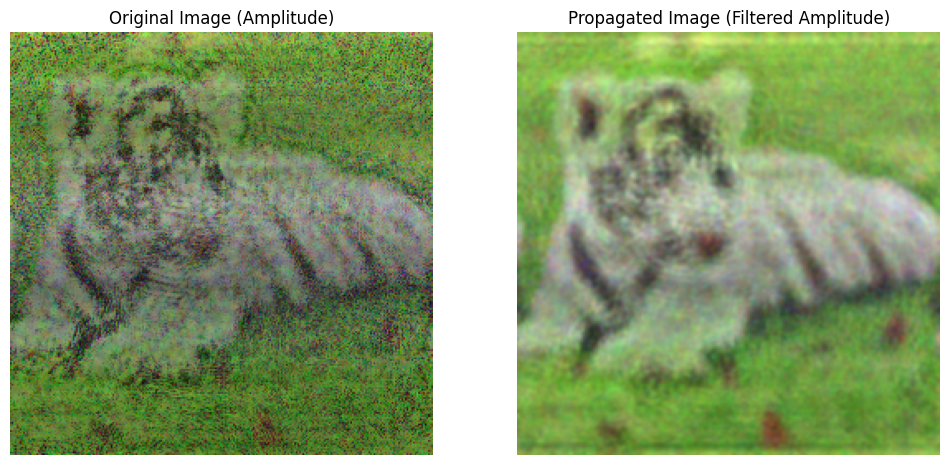

In [13]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.ndimage import zoom, gaussian_filter

# Propagation function using Fourier optics principles
def propagate(field, distance, wavelength, pixel_size):
    """
    Parameters:
        field: torch.Tensor - The input complex field (HxW complex tensor)
        distance: float - Propagation distance in meters
        wavelength: float - Wavelength in meters
        pixel_size: float - Pixel size in meters
    Returns:
        torch.Tensor - Propagated field
    """
    H, W = field.shape
    k = 2 * np.pi / wavelength  # Wavenumber

    # Create frequency coordinates
    fx = torch.fft.fftfreq(W, d=pixel_size)
    fy = torch.fft.fftfreq(H, d=pixel_size)
    FX, FY = torch.meshgrid(fx, fy, indexing='ij')  # Correct indexing
    F2 = FX**2 + FY**2

    # Transfer function for free-space propagation
    sqrt_term = torch.clamp(1 - (wavelength**2) * F2, min=1e-10)  # Clamp to avoid invalid sqrt
    H = torch.exp(-1j * k * distance * torch.sqrt(sqrt_term))

    # Apply the propagation in Fourier domain
    field_ft = torch.fft.fft2(field)
    field_ft_prop = field_ft * H
    propagated_field = torch.fft.ifft2(field_ft_prop)

    return propagated_field

# Constants for propagation
wavelength = 515e-9  # 515 nm in meters
distance = 30e-3  # 30 mm in meters
pixel_size = 10e-6  # Pixel size in meters (10 μm)

# Convert the loaded data into a PyTorch tensor
data_tensor = torch.tensor(data, dtype=torch.complex64)  # Use single precision for efficiency

# Initialize propagated fields for each color channel
propagated_fields = []

# Perform propagation for each channel
for channel in range(3):  # Loop through R, G, B channels
    field = data_tensor[:, :, channel]  # Extract channel data (complex field)
    propagated_field = propagate(field, distance, wavelength, pixel_size)
    propagated_fields.append(torch.abs(propagated_field))  # Store amplitude

# Combine propagated channels into an RGB image
propagated_image = torch.stack(propagated_fields, dim=-1).numpy()

# Apply Gaussian filter to reduce noise
propagated_image_filtered = np.empty_like(propagated_image)
for channel in range(3):  # Apply filter to each RGB channel
    propagated_image_filtered[:, :, channel] = gaussian_filter(propagated_image[:, :, channel], sigma=2)

# Normalize the propagated image for visualization
propagated_image_normalized = propagated_image_filtered / np.max(propagated_image_filtered)

# Convert data tensor to NumPy for visualization
data_numpy = data_tensor.numpy()  # Convert tensor to NumPy array
original_amplitude = np.abs(data_numpy)  # Take amplitude from the original complex data
original_amplitude_normalized = original_amplitude / np.max(original_amplitude)  # Normalize

# Downscale propagated image for display (optional, e.g., reduce size by 2x)
propagated_image_normalized = zoom(propagated_image_normalized, zoom=(0.5, 0.5, 1), order=1)  # Downscale 2x
original_amplitude_downscaled = zoom(original_amplitude_normalized, zoom=(0.5, 0.5, 1), order=1)  # Downscale 2x

# Plot the results
plt.figure(figsize=(12, 6))

# Plot original image (amplitude of input field)
plt.subplot(1, 2, 1)
plt.title("Original Image (Amplitude)")
plt.imshow(original_amplitude_downscaled, cmap='viridis')
plt.axis('off')

# Plot propagated image
plt.subplot(1, 2, 2)
plt.title("Propagated Image (Filtered Amplitude)")
plt.imshow(propagated_image_normalized)
plt.axis('off')

plt.show()
